In [79]:
import pandas as pd 
import numpy as np 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from category_encoders.count import CountEncoder
from sklearn.feature_selection import SelectFromModel 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import chi2_contingency
sns.set_theme()

In [3]:
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [5]:
train = reduce_mem_usage(df=train)
test = reduce_mem_usage(df=test)

Mem. usage decreased from 216.76 Mb to 141.86 Mb (34.6% reduction)
Mem. usage decreased from 216.02 Mb to 141.84 Mb (34.3% reduction)


In [6]:
dis_col = [col for col in train.columns if train[col].dtype in ["int32", "int8"] and col not in ["ID", "target"]]
cat_col = [col for col in train.columns if train[col].dtype == "O"]
cont_col = [col for col in train.columns if col not in dis_col + cat_col + ["ID", "target"]]

### Discrete features

In [7]:
# after analysing the discrete features i noticed that v38 = v72 - (v62 + v129), 
# so here we have a choice either we keep all those features or we use the v38
# or we can drop either (v62, v72, v129) or v38, i will keep them as a preprocessing that has been done for us 
train[dis_col].head()

,v38,v62,v72,v129
0,0,1,1,0
1,0,2,2,0
2,0,1,3,2
3,0,1,2,1
4,0,1,1,0


### Categorical features

In [8]:
# The first thing we can do analyzing a categorical features is to plot the distribution of each
# first this will give us some insight about how the data is distributed (no cardinality/ 2 or more cardinality)
# or is there no variance eg: {A:99.90%, B:0.10%}
train[cat_col].head()

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z


In [9]:
# let's devide the categorical features into 2 groups 
# group1 with low cardinality
# group2 with high cardinality
low_card = []
high_card = []
for col in cat_col:
    if train[col].nunique() > 10:
        high_card.append(col)
    else:
        low_card.append(col)
print("cattegoriacl columns with low cardinality: ",low_card)
print("cattegoriacl columns with high cardinality: ",high_card)

cattegoriacl columns with low cardinality:  ['v3', 'v24', 'v30', 'v31', 'v47', 'v66', 'v71', 'v74', 'v75', 'v91', 'v107', 'v110']
cattegoriacl columns with high cardinality:  ['v22', 'v52', 'v56', 'v79', 'v112', 'v113', 'v125']


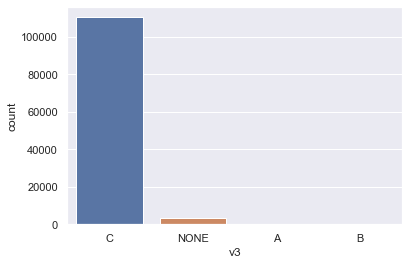

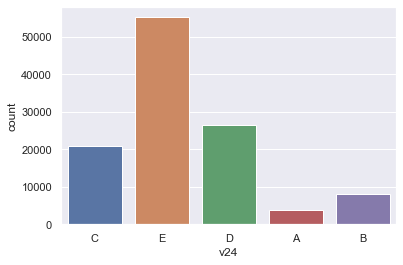

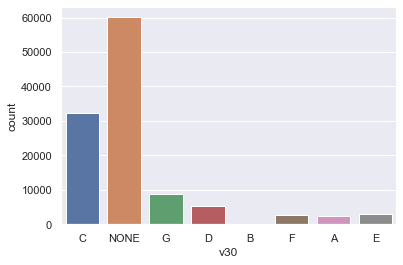

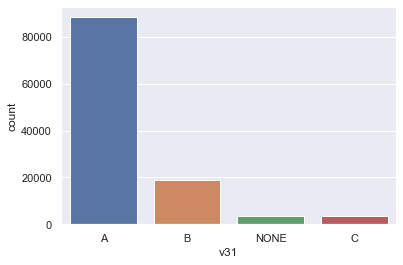

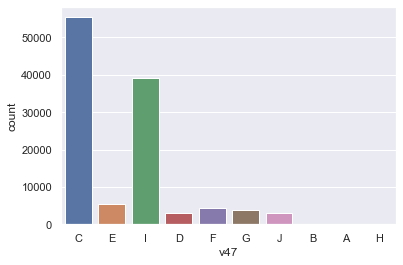

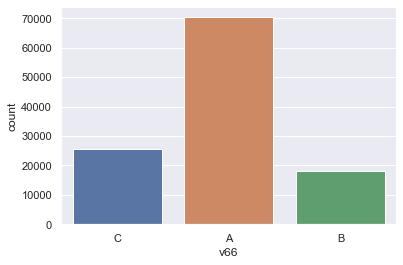

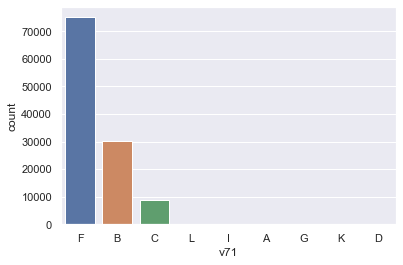

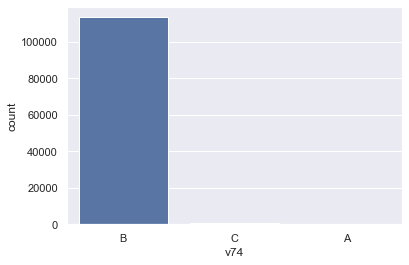

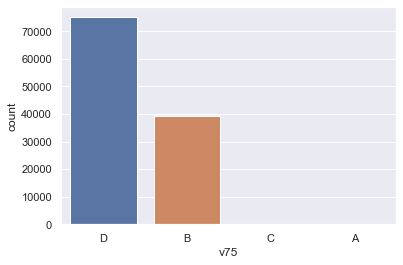

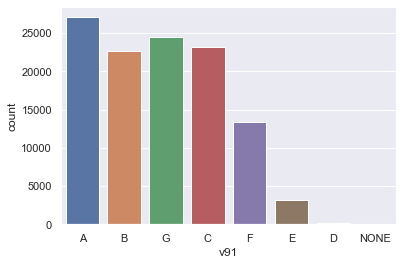

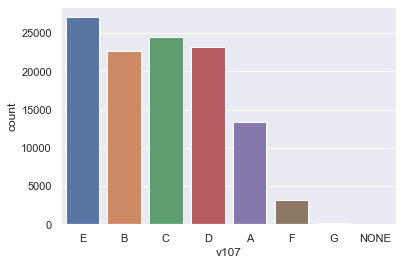

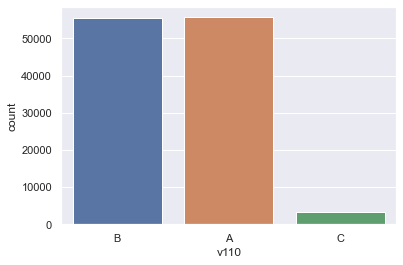

In [10]:
# fill nan value with NONE, this will help us to visualize the percentage of nan
# and see if there is a relation between nan value and other categories 
train[cat_col] = train[cat_col].fillna(value="NONE")
for col in low_card:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=train)

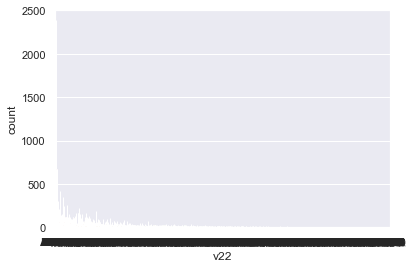

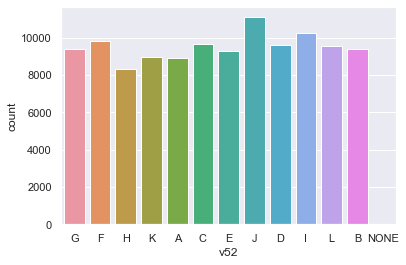

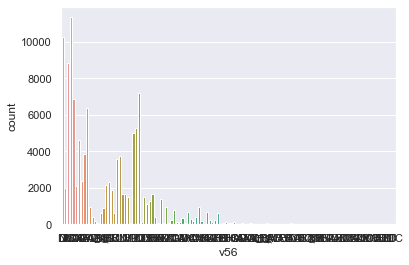

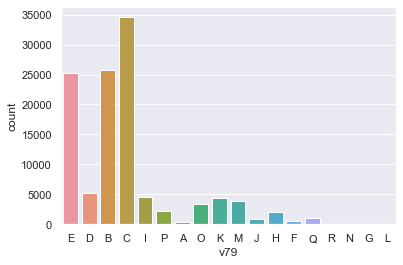

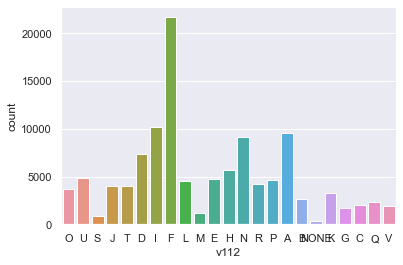

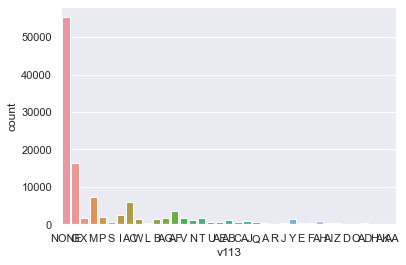

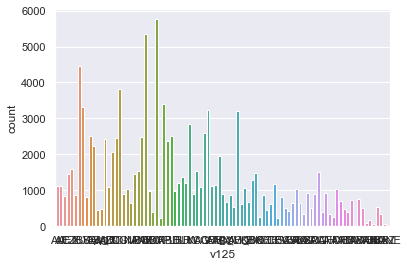

In [11]:
# dist plot of high cardinality features
for col in high_card:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=train)

In [11]:
# as you can see from the distribution plot we have some similarity between (v91, v107) we can drop one of them.
# if we take a look at (v71, v75) dist(F) = dist(D) and dist(B+C) = dist(B) // we can merge them 
# also (v3, v31) dstribution of NONE are equal 
# there are some unbalanced features like (v74,v3)
# v52 nan ~ v91 nan ~ v107 nan
# v112 S ~ v125 AE
# v47 H ~ v56 AX
# v22 has too many different values 23419 values in 228714 samples
# v112 and v125 have similar distribution the difference is that v125 has high cardinality than v112
# same for v56 and v79

#================================================================================================================

# the target mean is about 0.76
train["target"].mean()

0.7611987298921458

In [12]:
# we can see below the information gain table between categorical features and target 
# some of the category of the var v3 has good information gain of the target
# v24 provides no information gain as each category has a 0.76 probability for the target.
for col in low_card:
    print("=========================================================")
    print(f"information gain between {col} and target")
    print(train.groupby(col).target.agg(['mean', 'count']))
    print("=========================================================")
    print("=========================================================")

information gain between v3 and target
          mean   count
v3                    
A     0.955947     227
B     0.886792      53
C     0.759396  110584
NONE  0.804165    3457
information gain between v24 and target
         mean  count
v24                 
A    0.732119   3789
B    0.763313   8150
C    0.799588  20872
D    0.744389  26333
E    0.756384  55177
information gain between v30 and target
          mean  count
v30                  
A     0.791613   2313
B     0.873171    205
C     0.774473  32178
D     0.721914   5225
E     0.689876   2973
F     0.806489   2589
G     0.721586   8728
NONE  0.763284  60110
information gain between v31 and target
          mean  count
v31                  
A     0.720930  88347
B     0.911068  18947
C     0.920728   3570
NONE  0.804165   3457
information gain between v47 and target
         mean  count
v47                 
A    0.921053     38
B    0.820000     50
C    0.831502  55425
D    0.795375   3157
E    0.627429   5301
F    0.734382   4

In [13]:
# v52 provides no information gain as each category has a 0.76 probability for the target.
# in contrast v22 give some information gain ...
for col in high_card:
    print("=========================================================")
    print(f"information gain between {col} and target")
    print(train.groupby(col).target.agg(['mean', 'count']))
    print("=========================================================")
    print("=========================================================")

information gain between v22 and target
          mean  count
v22                  
AA    0.800000      5
AAA   1.000000      3
AAAA  1.000000      1
AAAB  0.923077     13
AAAC  1.000000      2
...        ...    ...
ZZS   0.000000      1
ZZU   1.000000      1
ZZV   0.000000      1
ZZW   0.833333     48
ZZZ   0.800000      5

[18211 rows x 2 columns]
information gain between v52 and target
          mean  count
v52                  
A     0.766499   8925
B     0.764838   9385
C     0.763351   9681
D     0.756428   9607
E     0.755010   9282
F     0.752091   9806
G     0.754963   9419
H     0.772918   8323
I     0.756823  10260
J     0.756102  11103
K     0.766454   8949
L     0.772186   9578
NONE  1.000000      3
information gain between v56 and target
         mean  count
v56                 
A    0.983871    186
AA   0.883333     60
AB   1.000000      2
AC   1.000000     11
AE   0.500000      2
..        ...    ...
V    0.911307   1477
W    1.000000      7
X    1.000000      1
Y    0.

In [14]:
# If we analyze the features v22 and v91 together, we can observe a significant pattern in the target variable.
# we can suspect that there are a lot of interaction between categorical variable (this can improve our score at the end)
train.groupby(['v91', 'v22']).target.agg(['mean', 'count'])

mean  count
v91  v22                  
A    AA    1.000000      2
     AAA   1.000000      1
     AAAG  0.000000      2
     AAAK  0.733333     15
     AAAN  1.000000      1
...             ...    ...
G    ZZW   0.923077     13
     ZZZ   1.000000      2
NONE ADMP  1.000000      1
     AGXM  1.000000      1
     NONE  1.000000      1

[40117 rows x 2 columns]

In [15]:
# Let's analyse the dependance between categorical variable
# If p-value <= alpha: significant result, reject null hypothesis (H0), dependent.
# If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent.
data_crosstab = pd.crosstab(train['v91'],
                            train['v107'], 
                               margins = True)
#print(data_crosstab)
stat, p, dof, expected = chi2_contingency(data_crosstab)

# interpret p-value
alpha = 0.05
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Dependent (reject H0)


In [33]:
def interaction_cat_col(df, cat_cols):
    """
    This function is used for detecting the dependence between the categorical variable 
    :param df: the pandas dataframe with train/test data
    :param cat_cols: list of categorical columns
    :return: dataframe with new features
    """
    # this will create all 2-combinations of values
    # in this list
    # for example:
    # list(itertools.combinations([1,2,3], 2)) will return
    # [(1, 2), (1, 3), (2, 3)]
    dependent_list = []
    combi = list(itertools.combinations(cat_cols, 2))
    for c1, c2 in combi:
        data_crosstab = pd.crosstab(df[c1],
                                    df[c2], 
                                    margins = True)
        #print(data_crosstab)
        stat, p, dof, expected = chi2_contingency(data_crosstab)

        # interpret p-value
        alpha = 0.05
        if p <= alpha:
            dependent_list.append((c1,c2))
        else:
            pass
    return dependent_list

In [35]:
# we can suspect that there are interactions between categorical features
# return list of cat-col
my_list = interaction_cat_col(train, cat_cols=cat_col)
#my_list

### Continuous features

In [16]:
# First thing we can conclude from the table is that the "nan" value are not randomly missing and i suspect that there is 
# some information behind those "nan" some columns have the same number of missing values 
train[cont_col].head(10)

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v120,v121,v122,v123,v124,v126,v127,v128,v130,v131
0,1.335938,8.726562,3.921875,7.914062,2.599609,3.177734,0.012939,10.000000,0.503418,16.437500,...,1.059570,0.803711,8.000000,1.990234,0.035767,1.803711,3.113281,2.023438,0.636230,2.857422
1,NaN,NaN,NaN,9.187500,NaN,NaN,2.300781,NaN,1.312500,NaN,...,NaN,NaN,NaN,NaN,0.599121,NaN,NaN,1.958008,NaN,NaN
2,0.943848,5.308594,4.410156,5.324219,3.980469,3.927734,0.019638,12.664062,0.765625,14.757812,...,2.138672,2.238281,9.335938,2.478516,0.013451,1.773438,3.921875,1.120117,0.883301,1.176758
3,0.797363,8.304688,4.226562,11.625000,2.097656,1.987305,0.171997,8.968750,6.542969,16.343750,...,1.166016,1.956055,7.019531,1.812500,0.002268,1.415039,2.955078,1.991211,1.676758,1.034180
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.050781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,8.859375,NaN,NaN,0.360107,NaN,1.050781,NaN,...,NaN,NaN,NaN,NaN,0.049866,NaN,NaN,1.536133,NaN,NaN
6,0.899902,7.312500,3.494141,9.945312,1.925781,1.770508,0.066223,5.011719,2.341797,16.281250,...,0.846680,2.232422,3.476562,1.992188,0.083740,3.275391,1.623047,2.265625,2.263672,0.970703
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.837891,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.078125,8.460938,3.738281,5.265625,1.573242,2.302734,0.015869,11.109375,4.464844,16.046875,...,1.414062,1.276367,8.148438,1.875977,0.018661,1.159180,5.582031,1.105469,1.170898,3.333984
9,1.144531,5.878906,3.244141,9.539062,2.500000,1.559570,0.412598,9.976562,2.363281,16.093750,...,0.434814,2.716797,7.324219,4.898438,0.008942,1.344727,1.601562,1.927734,3.173828,1.000000


In [29]:
# some features have the same number of null value we can suspect that there is a relation between those features
missing_df = pd.DataFrame(train[cont_col].isnull().sum()).reset_index()
missing_df.columns = ["cont_features", "missing_value"]
missing_df

,cont_features,missing_value
0,v1,49832
1,v2,49796
2,v4,49796
3,v5,48624
4,v6,49832
...,...,...
103,v126,49832
104,v127,49832
105,v128,48624
106,v130,49843


<Figure size 432x576 with 0 Axes>

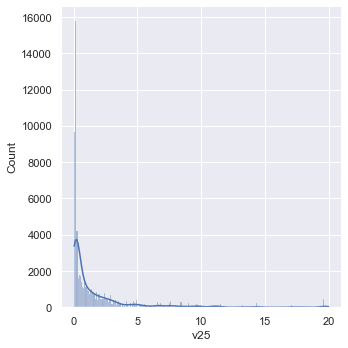

<Figure size 432x576 with 0 Axes>

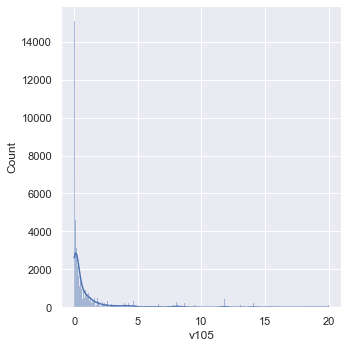

<Figure size 432x576 with 0 Axes>

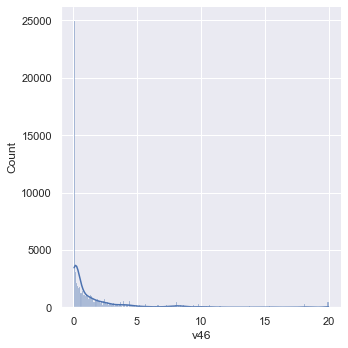

<Figure size 432x576 with 0 Axes>

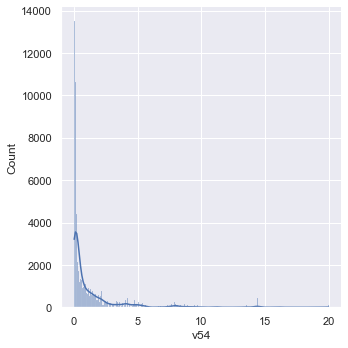

<Figure size 432x576 with 0 Axes>

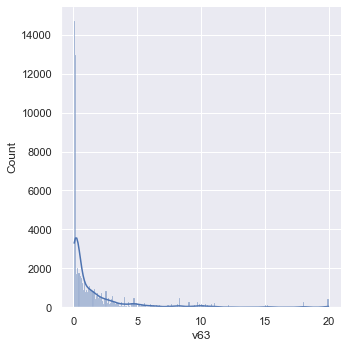

<Figure size 432x576 with 0 Axes>

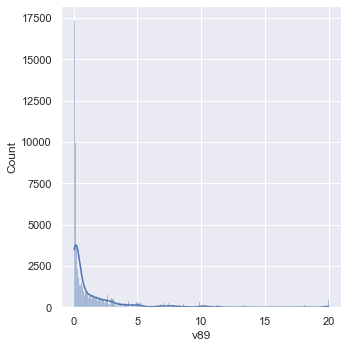

In [49]:
# after a lot of visualization i found similarity between some features distribution and there are highly correlated corr > 0.9 (see below)
for col in ["v25", "v105", "v46", "v54", "v63", "v89"]:
    plt.figure(figsize=(6,8))
    sns.displot(data=train, x=col, kde=True)
    plt.show()

In [50]:
# correlation between those features exceed 0.9
# let's see the whole continuous features and plot the correlation table
train[["v105", "v46", "v54", "v63", "v89"]].corr()

,v105,v46,v54,v63,v89
v105,1.000000,0.946006,0.939090,0.939527,0.922817
v46,0.946006,1.000000,0.918838,0.991609,0.931735
v54,0.939090,0.918838,1.000000,0.918711,0.956309
v63,0.939527,0.991609,0.918711,1.000000,0.930916
v89,0.922817,0.931735,0.956309,0.930916,1.000000


<AxesSubplot:>

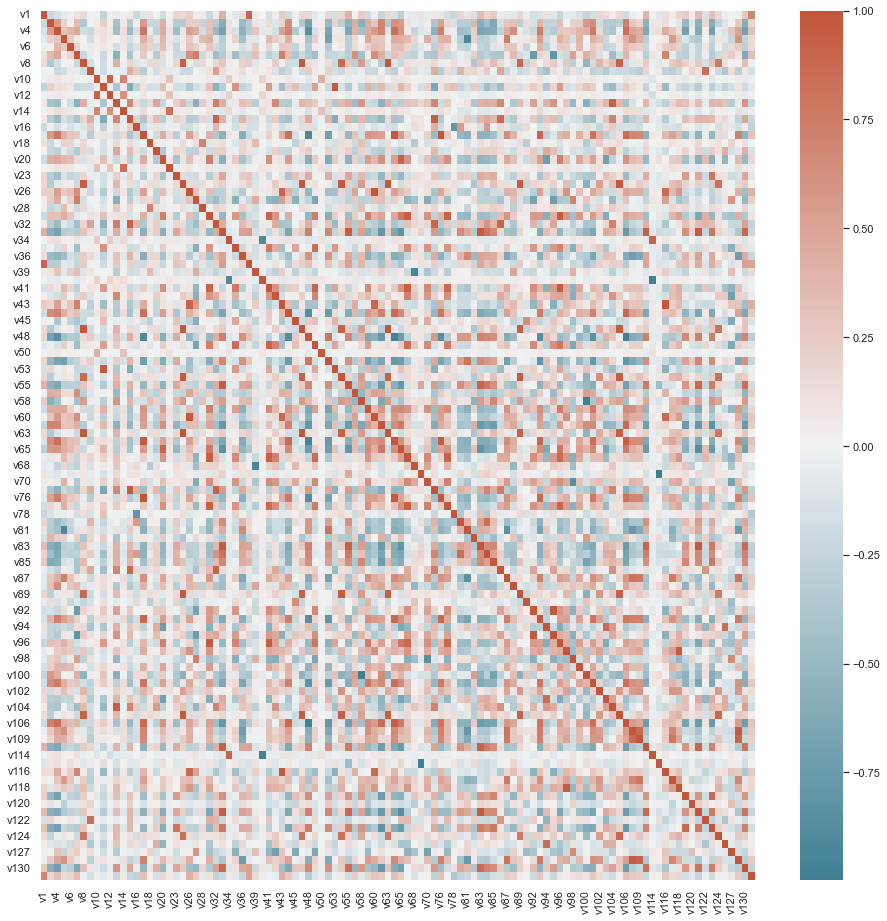

In [51]:
# visualise correlated features:

# I will build a correlation matrix, which examines the 
# correlation of all features (that is, for all possible feature combinations)
# and then visualise the correlation matrix using a heatmap

# the default correlation method of pandas.corr is pearson
corrmat = train[cont_col].corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(16,16)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

In [54]:
corrmat = train[cont_col].corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
#print(corrmat)
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,v58,v100,0.997665
1,v100,v58,0.997665
2,v115,v69,0.993692
3,v69,v115,0.993692
4,v76,v17,0.992672


In [56]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(train[cont_col].shape[1]))

found 22 correlated groups
out of 108 total features


In [63]:
# now we can print out each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0      v58     v100  0.997665

  feature1 feature2      corr
2     v115      v69  0.993692

   feature1 feature2      corr
4       v76      v17  0.992672
51      v76      v64  0.953865

   feature1 feature2      corr
6       v63      v46  0.991609
13      v63      v25  0.981051
23      v63       v8  0.975956
67      v63     v105  0.939527
77      v63      v89  0.930916
90      v63      v54  0.918711

   feature1 feature2      corr
14      v60      v26  0.980747

   feature1 feature2      corr
16     v106      v48  0.980726
70     v106      v64  0.933008

   feature1 feature2      corr
18     v116      v43  0.977873

   feature1 feature2     corr
20      v95      v92  0.97709

   feature1 feature2      corr
28     v114      v40  0.966913
99     v114      v34  0.912381

    feature1 feature2      corr
30       v83     v121  0.966239
34       v83      v33  0.964305
114      v83     v111  0.904088
124      v83      v55  0.901703

   feature1 feature2      corr

In [ ]:
# I tried to drop some highly correlated features but i found out that the performance does not improve it makes our model prediction worse
'''
drop_columns = []
for i in range(len(correlated_groups)):
    groups = list(correlated_groups[i]["feature2"].unique()) + list(correlated_groups[i]["feature1"].unique())
    # train a random forest 
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(train[groups].fillna(-9999), train["target"])
    
    # get the feature importance attributed by the 
    # random forest model 

    importance = pd.concat(
                           [pd.Series(groups),
                           pd.Series(rf.feature_importances_)], axis=1)

    importance.columns = ['feature', 'importance']

    # sort features by importance, most important first
    print(importance.sort_values(by='importance', ascending=False))
    importance = importance.sort_values(by='importance', ascending=False)
    drop_features = list(importance["feature"].values)
    print(drop_features[1:])
    drop_columns.extend(drop_features[1:])

drop_columns 
'''

In [64]:
# this kind of imputation is simple but in our case, it will give some meaning information to our based tree model
# based tree model will separate the branch in two leafs for categorical features (NONE and other categories)
# for continuous features (999, and othe numercal...)
# no scaling needed when using tree based model 
for col in cat_col:
    train[col] = train[col].fillna(value="NONE")
for col in cont_col:
    train[col] = train[col].fillna(value=999)

In [76]:
def create_fold(data, num_fold, target):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    Kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
    for num_fold , (train_idx, val_idx) in enumerate(Kf.split(X=data,
                                                             y=data[target].values)):
        print(f"for fold {num_fold}", f", we will train on {len(train_idx)} samples",f", and validate on {len(val_idx)} samples")
        data.loc[val_idx, "kfold"] = num_fold
    return data

In [ ]:
# I tried almost all kind of features selections 
# 1. Filter method
# 2. wrapper method
# 3. embedded method 
# I go for the last method using xgboostclassifier
# below feature selection using logistic regression with {C:regularization strength}, smaller values specify stronger regularization.
'''
for col in cat_col:
    lbe = LabelEncoder()
    train.loc[:,col] = lbe.fit_transform(train[:,col])
train = create_fold(data=train, num_fold=5, target= "target")
dis_col = [col for col in train.columns if train[col].dtype in ["int32", "int8"] and col not in ["ID", "target", "kfold"] and train[col].nunique()>2]
cat_col = [col for col in train.columns if train[col].dtype == "O"]
cont_col = [col for col in train.columns if col not in dis_col + cat_col + ["ID", "target", "kfold"] and train[col].nunique()>2]
scaler = StandardScaler()
scaler.fit(train[cont_col + dis_col])
train[cont_col + dis_col] = scaler.transform(train[cont_col + dis_col])
sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))
features = [col for col in train.columns if col not in ["ID", "target", "kfold"]]
sel_.fit(train[features], train["target"])
selected_feat = train[features].columns[sel_.get_support()]
'''

for fold 0 , we will train on 91456 samples , and validate on 22865 samples
for fold 1 , we will train on 91457 samples , and validate on 22864 samples
for fold 2 , we will train on 91457 samples , and validate on 22864 samples
for fold 3 , we will train on 91457 samples , and validate on 22864 samples
for fold 4 , we will train on 91457 samples , and validate on 22864 samples


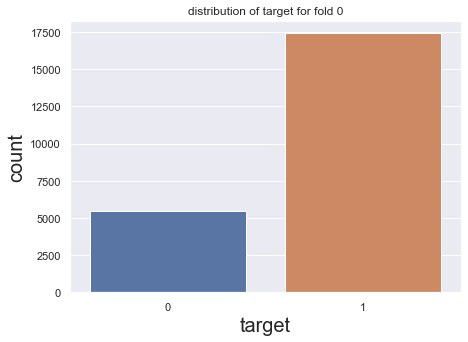

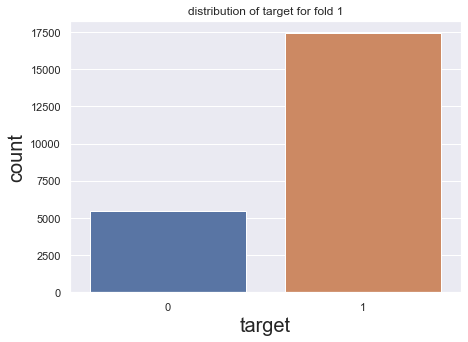

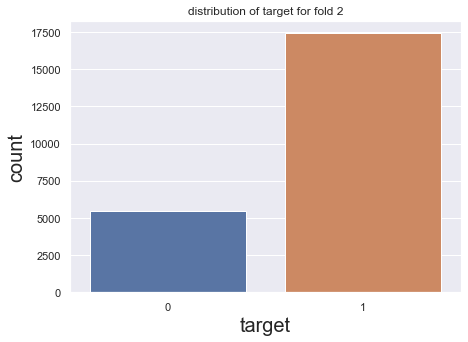

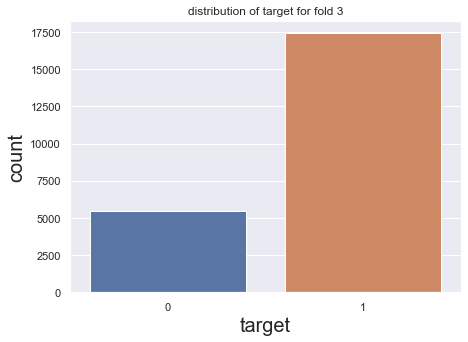

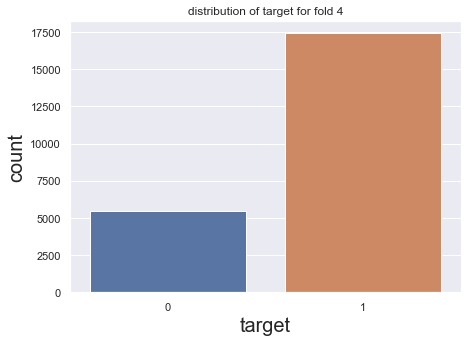

In [78]:
# I used stratifiedkfold because we want the same distribution throughout our training process 
# This will help us to generalize the model 
train = create_fold(data=train, num_fold=5, target="target")
for fold in range(5):
    plt.figure(figsize=(7,5))
    counts = train.loc[train["kfold"]==fold,"target"].value_counts()
    bar = sns.barplot(x=counts.index, y=counts.values)
    bar.set_title(f"distribution of target for fold {fold}")
    bar.set_xlabel("target", fontsize=20)
    bar.set_ylabel("count", fontsize=20)

In [ ]:
useful = [col for col in train.columns if col not in ["ID", "target", "kfold"]]

In [ ]:
for col in cat_col:
    lbe = LabelEncoder()
    train.loc[:,col] = lbe.fit_transform(train[:,col])

In [ ]:
def run(fold, data, features):
    print(fold,"------------------------------------------------------------")
    dt_train = data[data["kfold"]!=fold].reset_index(drop=True)
    
    x_train = dt_train[features]
    y_train = dt_train["target"]

    for col in cat_col:
        target_enc = TargetEncoder(min_samples_leaf=1, smoothing=1.0)
        x_train[col] = target_enc.fit_transform(x_train[col],y=y_train)

    sel = SelectFromModel(XGBClassifier())
    sel.fit_transform(x_train,y_train)
    importances = sel.estimator_.feature_importances_
    feat_importances = pd.Series(importances, index= useful)
    new_features = feat_importances.sort_values(ascending=False).head(25).index.tolist()
    print(new_features)
    print("------------------------------------------------------------------")
    print()

In [ ]:
for fold in range(5):
    run(fold=fold, data=train, features=useful)

In [ ]:
# for each fold we will get a useful set of features, and i will try out all of them and keep whose give the best score 
# useful = ['v22', 'v31', 'v50', 'v66', 'v110', 'v56', 'v113', 'v79', 'v129', 'v47', 'v3', 'v38', 'v74', 'v24', 'v75', 'v26', 'v46', 'v51', 'v72', 'v64', 'v32', 'v71', 'v100', 'v109', 'v89']+['v22', 'v31', 'v50', 'v66', 'v113', 'v56', 'v79', 'v47', 'v110', 'v74', 'v3', 'v38', 'v24', 'v129', 'v30', 'v40', 'v118', 'v49', 'v100', 'v35', 'v92', 'v10', 'v84', 'v116', 'v117']+['v22', 'v31', 'v50', 'v66', 'v56', 'v129', 'v110', 'v113', 'v79', 'v47', 'v74', 'v3', 'v38', 'v24', 'v40', 'v72', 'v10', 'v100', 'v124', 'v73', 'v67', 'v36', 'v49', 'v35', 'v44']+['v22', 'v31', 'v50', 'v66', 'v47', 'v56', 'v110', 'v113', 'v129', 'v79', 'v3', 'v38', 'v24', 'v74', 'v75', 'v40', 'v72', 'v87', 'v48', 'v105', 'v111', 'v10', 'v118', 'v32', 'v20']+['v22', 'v31', 'v50', 'v66', 'v110', 'v79', 'v56', 'v113', 'v47', 'v75', 'v74', 'v129', 'v24', 'v8', 'v3', 'v30', 'v72', 'v40', 'v83', 'v94', 'v18', 'v92', 'v73', 'v76', 'v58']
# useful1 = ['v22', 'v31', 'v50', 'v66', 'v110', 'v56', 'v113', 'v79', 'v129', 'v47', 'v3', 'v38', 'v74', 'v24', 'v75', 'v26', 'v46', 'v51', 'v72', 'v64', 'v32', 'v71', 'v100', 'v109', 'v89']
# useful2 = ['v22', 'v31', 'v50', 'v66', 'v113', 'v56', 'v79', 'v47', 'v110', 'v74', 'v3', 'v38', 'v24', 'v129', 'v30', 'v40', 'v118', 'v49', 'v100', 'v35', 'v92', 'v10', 'v84', 'v116', 'v117']
# useful3 = ['v22', 'v31', 'v50', 'v66', 'v56', 'v129', 'v110', 'v113', 'v79', 'v47', 'v74', 'v3', 'v38', 'v24', 'v40', 'v72', 'v10', 'v100', 'v124', 'v73', 'v67', 'v36', 'v49', 'v35', 'v44']
# useful4 = ['v22', 'v31', 'v50', 'v66', 'v47', 'v56', 'v110', 'v113', 'v129', 'v79', 'v3', 'v38', 'v24', 'v74', 'v75', 'v40', 'v72', 'v87', 'v48', 'v105', 'v111', 'v10', 'v118', 'v32', 'v20']
# useful5 = ['v22', 'v31', 'v50', 'v66', 'v110', 'v79', 'v56', 'v113', 'v47', 'v75', 'v74', 'v129', 'v24', 'v8', 'v3', 'v30', 'v72', 'v40', 'v83', 'v94', 'v18', 'v92', 'v73', 'v76', 'v58']